In [14]:
%matplotlib inline

from modsim import *

In [15]:
tc= 3        #time between contacts in days
tr =4        #recovery time in days
th=2         #time sick but appear healthy in days

beta=1/tc    #contact rate in per day
gamma =1/tr  #recovery rate in per day
omega= 1/th  #sick appearance rate in per day

alpha = .6   #percent of sick people who take medicine

In [16]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=349, I_H=1, I_M=0, I_NM=0, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [17]:
def plot_results(S, I_H, I_M, I_NM, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    I_H: TimeSeries
    I_U: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I_H, '-', color='red', label='Infected but Appear Healthy')
    plot(I_M, '-', color='purple', label='Infected and are Taking Medicine')
    plot(I_NM, '-', color='orange', label='Infected and are not Taking Medicine')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [18]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [19]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for i in linrange(t0, t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
    
    system.results = frame

In [20]:
def update1(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    
    #I'm not sure if this works or not
    #We should talk about it
    
    
    s, i_h, i_m, i_nm, r = state

    unpack(system)
    
    
    still_IH = i_h * omega
    new_IH = s * (i_h + i_m + i_nm ) * beta
    infected_Healthy = still_IH + new_IH
    
    still_IM = (1-gamma)*i_m
    new_IM = alpha * i_h * (1-omega)
    infected_Med = still_IM + new_IM
    
    stillNM = (1-gamma)*i_nm
    newNM = (1-alpha)*i_h*(1-omega)
    infected_No_Med = stillNM + newNM
    
    recovered = gamma * (i_m + i_nm)
    
    s -= infected_Healthy
    i_h +=  infected_Healthy -infected_Med -infected_No_Med
    i_m += infected_Med -(recovered*alpha)
    i_nm += infected_No_Med-recovered*(1-alpha)
    r += recovered
    
    return State(S=s, I_H=i_h, I_M=i_m, I_NM=i_nm, R=r)

In [21]:
system = make_system(beta, gamma)
run_simulation(system, update1)
system.results.head()

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


,S,I_H,I_M,I_NM,R
0,0.997143,0.002857,0.000000,0.000000,0.000000
1,0.994765,0.003807,0.000857,0.000571,0.000000
2,0.991125,0.004471,0.002428,0.001619,0.000357
3,0.986076,0.004251,0.004983,0.003322,0.001369
4,0.979823,0.002149,0.008750,0.005833,0.003445


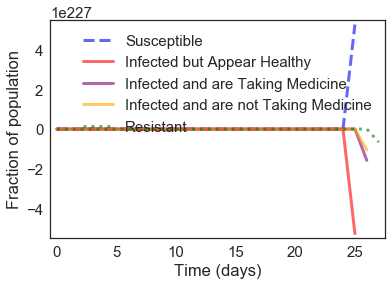

In [22]:
frame = system.results
plot_results(frame.S, frame.I_H, frame.I_M, frame.I_NM, frame.R)

In [17]:
beta_array = linspace(0.1, 0.9, 11)
gamma = 0.25

In [21]:
for beta in beta_array:
    system = make_system(beta, gamma)
    run_simulation(system, update1)
    system.beta, calc_total_infected(system)

In [22]:
def sweep_beta(beta_array, gamma):
    """SweepSeriess a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        run_simulation(system, update1)
        sweep[system.beta] = calc_total_infected(system)
    return sweep

In [23]:
infected_sweep = sweep_beta(beta_array, gamma)

Saving figure to file chap06-fig01.pdf


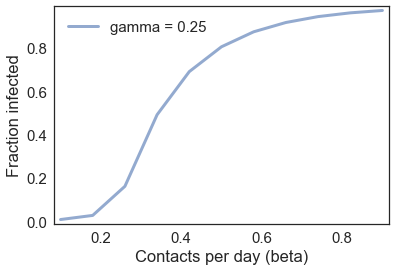

In [24]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('chap06-fig01.pdf')